In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
import glob

In [7]:
files = glob.glob("/mnt/data/yanzi/xiaomi_vacuum_as_data_collector/data_parsed_all/*.pickle")
files_png = glob.glob("/mnt/data/yanzi/xiaomi_vacuum_as_data_collector/data_parsed_all/*.png")

In [8]:
def file_info(fname):
    parts = fname.split('/')[-1].split('_')
    date, time, dev, mac, _, pkt_type, _ = parts[:7]
    return date, time, dev, mac, pkt_type

In [9]:
import pickle
import numpy as np

In [10]:
import os
import sys
sys.path.append("/home/gomezp/advloc")
from models import create_model
from options.test_options import TestOptions
import torch
from data.rss_dataset import RSSDataset

In [11]:
# hack to avoid passing command-line arguments
sys.argv = ["--seed=666", "--gpu_ids=1",
            "--dataroot=''", "--name=rss_v3_8",
            "--model=rssmap2rssmap", "--input_nc=1",
            "--output_nc=1", "--norm=batch",
            "--dataset_mode=rss", "--num_threads=0",
            "--batch_size=1", "--netG=unet_64",
            "--verbose", "--no_flip", "--serial_batches"]
opt = TestOptions().parse()  # get test options
opt.display_id = -1 # do not use visdom; we will save plots ourselves

dataset = RSSDataset(opt)
model = create_model(opt)

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
             blocked_size: 0                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ''                            	[default: None]
             dataset_mode: rss                           	[default: aligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 1                             	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
                  isTrain: 

In [12]:
def test_single(A_path):
    with open(A_path, 'rb') as f:
        data_A = pickle.load(f)
    if data_A[1] is None:
        return
    
    # Extract ground truth from file
    date, time, dev, mac, pkt_type = file_info(A_path)
    map_A, x, y = data_A[0], *data_A[1]
    loc = np.array([x, y])
    
    # Prepare image as model input
    map_A = torch.tensor(dataset.normalize_data(map_A), dtype=torch.float32)
    map_A = map_A.view((1, map_A.size()[0], -1)).unsqueeze(0)

    tx_loc_np = (loc - 32.) / 64.
    # `normalize_loc` is not correct here: input coords are i [0,64] range, not [-5,5]
    #tx_loc_np = dataset.normalize_loc(loc)
    tx_loc = torch.tensor(tx_loc_np).float()
    tx_pwr_np = dataset.normalize_data(np.array([-34])) # hack; figure this out!
    tx_pwr = torch.tensor(tx_pwr_np).float()
    tx_loc_pwr = torch.cat((tx_loc, tx_pwr))

    # Pack input data
    data = {'A': map_A, 'B': map_A, 'A_paths': A_path, 'B_paths': A_path, 'tx_loc_pwr': tx_loc_pwr}
    
    realA = map_A.squeeze().numpy()
    
    # Forward and extract visuals
    model.set_input(data)
    model.test()
    visuals = model.get_current_visuals()
    visuals_np = {}
    for v in visuals:
        t = visuals[v]
        visuals_np[v] = t.cpu().float().squeeze().numpy()
    
    # Extract transmitter location from latent space
    task_tx_loc = model.latent[:2].cpu().float().squeeze().numpy()
    
    #return realA, realB, visuals_np, tx_loc_np, tx_pwr_np, task_tx_loc
    return realA, visuals_np, loc, task_tx_loc

In [49]:
def l2(x):
    from math import sqrt
    return sqrt(np.sum(x**2))
def l1(x):
    return np.sum(abs(x))
def denorm_rss(x):
    return ((x + 1) / 2) * (dataset.max_rss - dataset.min_rss) + dataset.min_rss

def test(epoch):
    opt.epoch = epoch
    opt.load_iter = 0
    from IPython.utils import io
    with io.capture_output() as captured:
        model.setup(opt)
    
    loc_diffs = []
    rss_diffs = []
    
    for idx, fname in enumerate(files):
        res = test_single(fname)
        if res is None:
            continue
        real_A, visuals, loc, task_loc = res
        
        # compute localization error
        loc = (loc - 32.) / 64.
        loc_diffs.append(l2(loc[::-1] - task_loc))
        
        # compute rss error
        fake_B = visuals['fake_B']
        scaled_fake_B = denorm_rss(fake_B)
        scaled_real_A = denorm_rss(real_A)
        rss_diffs.append(l1(scaled_real_A - scaled_fake_B) / real_A.size)
        

    loc_diffs = np.array(loc_diffs)
    rss_diffs = np.array(rss_diffs)
    return [[ loc_diffs.mean(), loc_diffs.std(), loc_diffs.min(), loc_diffs.max() ],
        [ rss_diffs.mean(), rss_diffs.std(), rss_diffs.min(), rss_diffs.max() ]]

loading the model from ./checkpoints/rss_v3_8/200_net_G.pth
---------- Networks initialized -------------
DataParallel(
  (module): UnetGenerator(
    (model): UnetSkipConnectionBlock(
      (model): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): UnetSkipConnectionBlock(
          (model): Sequential(
            (0): LeakyReLU(negative_slope=0.2, inplace)
            (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): UnetSkipConnectionBlock(
              (model): Sequential(
                (0): LeakyReLU(negative_slope=0.2, inplace)
                (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (3): UnetSkipConnection

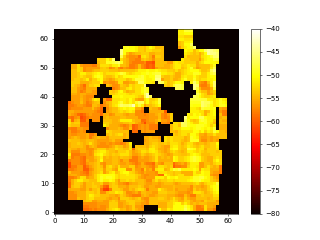

In [40]:
# Testing...
# ---------------------
opt.epoch = 200
opt.load_iter = 0
model.setup(opt)
idx = -16

_, _, loc, task_loc = test_single(files[idx])
print((loc - 32.) / 64., "\n", task_loc)

from IPython.display import Image
Image(filename=files_png[idx]) 

# Localization statistics
---------

In [55]:
%%time
#test_epoches = range(0,201,50)
test_epoches = [0, 50, 100, 150, 200]
diffs = []
print("Testing on epoch ", end="")
for epoch in test_epoches:
    print("{}, ".format(epoch), end="")
    diffs.append(test(epoch))
print("done!")

Testing on epoch 0, 50, 100, 150, 200, done!
CPU times: user 11.5 s, sys: 3.27 s, total: 14.8 s
Wall time: 14.8 s


## (1) Plot localization error

<ErrorbarContainer object of 3 artists>

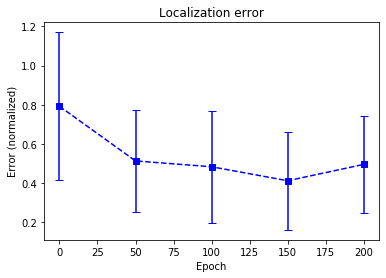

In [51]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Error (normalized)")
plt.title("Localization error")

test_epoches = list(test_epoches)
diffs = np.array(diffs)
loc_means = diffs[:,0,0]
loc_stds = diffs[:,0,1]
plt.errorbar(test_epoches, loc_means, loc_stds, marker="s", linestyle="--", color="blue", capsize=4)

## (2) Plot RSS error

<ErrorbarContainer object of 3 artists>

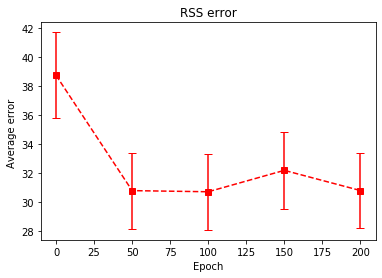

In [52]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Average error ")
plt.title("RSS error")

rss_means = diffs[:,1,0]
rss_stds = diffs[:,1,1]
plt.errorbar(test_epoches, rss_means, rss_stds, marker="s", linestyle="--", color="red", capsize=4)

## (3) Save raw data in JSON

In [35]:
import json
# Hack to serialize numpy arrays
class NPEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [36]:
json.dumps(diffs, cls=NPEncoder)

'[[[0.7922362956722008, 0.3778031441587197, 0.029083962046555636, 1.6901391404616748], [38.73011563074728, 2.9686311692381446, 33.682891845703125, 49.2869987487793]], [[0.5132166871226723, 0.26241206839137543, 0.02439152737876791, 1.4590239931986024], [30.79449338207913, 2.6169061767332464, 26.055604934692383, 39.688236236572266]], [[0.48341463510425464, 0.2854897415124176, 0.02563848554660117, 1.0565816798512095], [30.717486266496117, 2.6242906715730503, 25.805797576904297, 39.53767776489258]], [[0.4120156769277043, 0.2509677751638426, 0.007950627184224611, 0.9784358834205099], [32.18567032572824, 2.66497929517628, 27.032272338867188, 41.059471130371094]], [[0.49554682224085894, 0.2471855263558705, 0.04253955269631883, 1.0152496863744274], [30.79763441419787, 2.590141402792557, 25.840505599975586, 39.49962615966797]]]'